In [1]:
!wget https://github.com/kboroz/TimeSeriesPrediction/raw/main/Data/kddcup.data_10_percent_corrected.zip

!unzip kddcup.data_10_percent_corrected.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('kddcup.data_10_percent_corrected.csv', header=None)

# The last column is the label, separate it from the features
labels = data.iloc[:, -1]
features = data.iloc[:, :-1]

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.
494020,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming `features` and `labels` are already loaded as DataFrames

# Map labels to binary values
labels = labels.map({
    'normal.': 0,
    'neptune.': 1, 'warezclient.': 1, 'ipsweep.': 1, 'portsweep.': 1,
    'teardrop.': 1, 'nmap.': 1, 'satan.': 1, 'smurf.': 1, 'pod.': 1,
    'back.': 1, 'land.': 1, 'guess_passwd.': 1, 'ftp_write.': 1,
    'multihop.': 1, 'rootkit.': 1, 'phf.': 1, 'spy.': 1, 'perl.': 1,
    'buffer_overflow.': 1, 'imap.': 1, 'warezmaster.': 1, 'snmpguess.': 1,
    'snmpgetattack.': 1, 'httptunnel.': 1, 'ps.': 1, 'named.': 1,
    'xlock.': 1, 'xsnoop.': 1, 'sendmail.': 1, 'remote_to_local.': 1
})

# One-hot encode the categorical features (columns 1 to 3 in this dataset)
categorical_features = features.iloc[:, 1:4]  # Assuming these are categorical columns
encoded_features = pd.get_dummies(categorical_features, columns=categorical_features.columns)

# Concatenate the encoded features with the rest of the DataFrame
features_no_names = pd.concat([features.iloc[:, :1], encoded_features, features.iloc[:, 4:]], axis=1)

# Fix column name types to ensure consistency
features_no_names.columns = features_no_names.columns.astype(str)  # Convert all column names to strings

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features_no_names)

# Convert to FP32
features_scaled = features_scaled.astype(np.float32)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=123)

# Display shapes to confirm
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


x_train shape: (395216, 118), x_test shape: (98805, 118)
y_train shape: (395216,), y_test shape: (98805,)


In [7]:
import os
import datetime
import tensorflow as tf
from tensorflow.keras import Input, Model, optimizers
from tensorflow.keras.layers import Dense, Dropout

input_dim = x_train.shape[1]

# Model hyperparameters
batch_size = 512
latent_dim = 4
max_epochs = 10

# Encoder Network
input_data = Input(shape=(input_dim,), name='encoder_input')

encoder = Dense(96, activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64, activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48, activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16, activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

encoder_model = Model(input_data, latent_encoding)
encoder_model.summary()

# Decoder Network
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

autoencoder_model = Model(input_data, reconstructed_data)
autoencoder_model.summary()

# Compile the Model
opt = optimizers.Adam(learning_rate=.00001)
autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

# Train the Model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, profile_batch=0, update_freq='epoch', histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
                                    shuffle=True,
                                    epochs=max_epochs,
                                    batch_size=batch_size,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback])



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 96)             │        11,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,604 (84.39 KB)

 Trainable params: 21,604 (84.39 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 96)             │        11,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 48)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Dense)               │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstructed_data (Dense)      │ (None, 118)            │        11,446 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,322 (169.23 KB)

 Trainable params: 43,322 (169.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0089 - loss: 0.0790 - val_accuracy: 2.4290e-04 - val_loss: 0.0328
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0225 - loss: 0.0423 - val_accuracy: 0.2188 - val_loss: 0.0177
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0887 - loss: 0.0295 - val_accuracy: 0.2217 - val_loss: 0.0119
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1195 - loss: 0.0228 - val_accuracy: 0.2219 - val_loss: 0.0086
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1252 - loss: 0.0182 - val_accuracy: 0.1775 - val_loss: 0.0063
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1390 - loss: 0.0147 - val_accuracy: 0.1277 - val_loss: 0.0049
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1413 - loss: 0.0123 - val_accuracy: 0.1642 - val_loss: 0.0041
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1403 - loss: 0.0106 - val_accuracy

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 3s 839us/step


<Axes: ylabel='Frequency'>

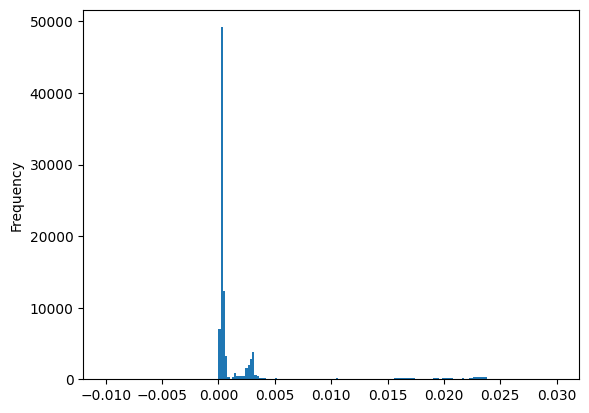

In [11]:
#Anomal detection
import matplotlib.pyplot as plt
# Reconstruct the data using the trained autoencoder model
x_test_recon = autoencoder_model.predict(x_test)

# The reconstruction score is the mean of the reconstruction errors
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)

# Store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score': reconstruction_scores})

# If our reconstruction scores are normally distributed, we can use their statistics
anomaly_data.describe()

# Plotting the density will give us an idea of how the reconstruction scores are distributed
plt.xlabel('Reconstruction Score')
anomaly_data['recon_score'].plot.hist(bins=200, range=[-.01, .03])


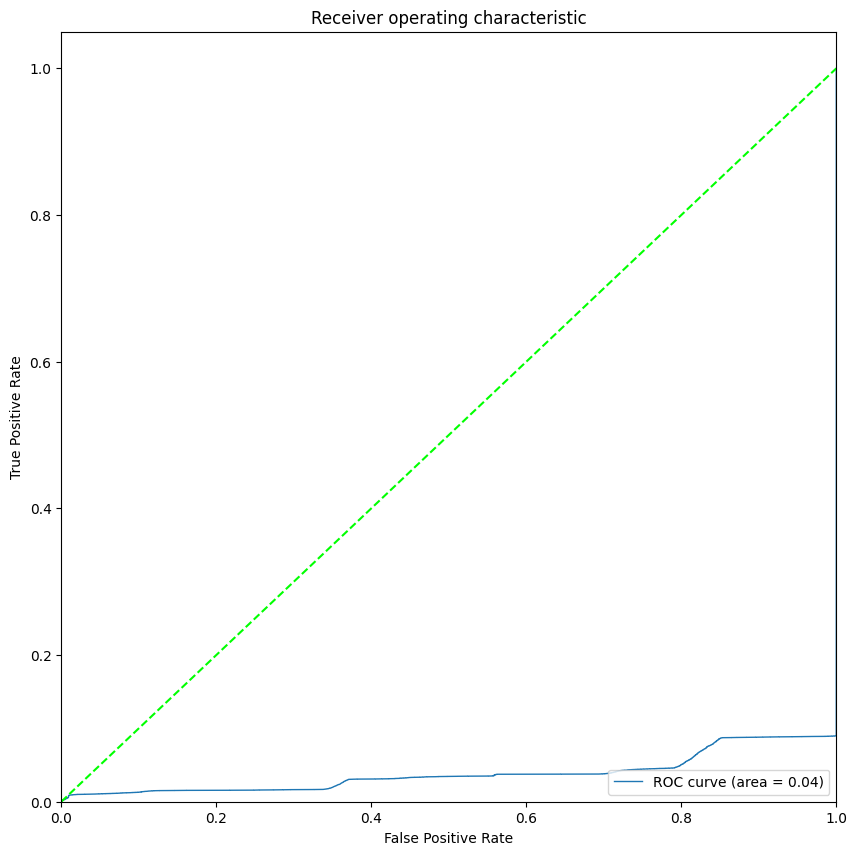

0.037623834
0.039471626
Confusion Matrix: 


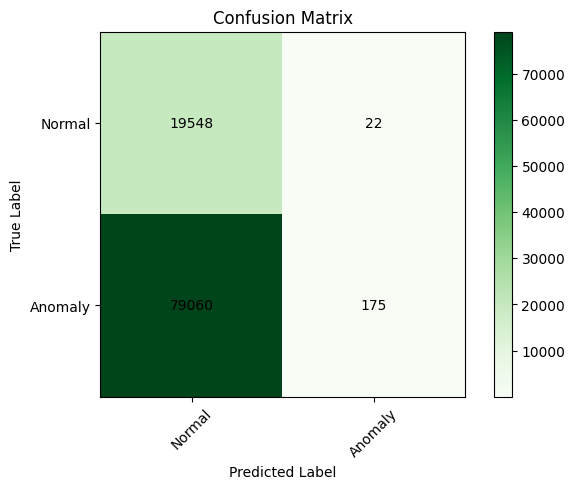

In [19]:
#threshold setting

# Convert our labels to binary (assuming 'normal' is 0 and 'anomaly' is 1)
def convert_label_to_binary(labels):
    normal_idx = np.where(labels == 0)
    my_labels = labels.copy()
    my_labels[my_labels != 0] = 1
    my_labels[my_labels == 0] = 0
    return my_labels

binary_labels = convert_label_to_binary(y_test)

# Add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# Check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Optimal Threshold
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

# Statistical Threshold
recon_mean = np.mean(reconstruction_scores)
recon_stddev = np.std(reconstruction_scores)
stats_threshold = recon_mean + 5*recon_stddev
print(stats_threshold)

# Choose a threshold
#thresh = stats_threshold  # or use optimal_threshold
thresh = optimal_threshold

# Predict labels based on the threshold
pred_labels = (reconstruction_scores > thresh).astype(int)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
results = confusion_matrix(binary_labels, pred_labels)
print ('Confusion Matrix: ')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plot_confusion_matrix(results, ['Normal','Anomaly'])
